<b><h1>Battle of the Neighborhoods Capstone Project</h1></b>

<h2>Introduction</h2>
<br>
An entrepreneur is interested in opening a new Filipino restaurant in the most ethnically diverse city in the United States, New York City. He/She has reached out for help to identify the best borough and neighborhood with high interest in Filipino cuisine. It would also be beneficial to learn about the potential competitors and see where most New Yorkers go to satisfy their Filipino food cravings. The main objective of the project is to learn more about the characteristics of the different boroughs and neighborhoods of New York city, and to figure out the best neighborhood to open a Filipino restaurant that can provide the best chance for success.

<h2>Problem Statements</h2>
<ol>
    <li>What location(s) in New York City best serve Filipino cuisines?</li>
    <li>Where do most New Yorkers go to have the best Filipino food in the city?</li>
    <li>In what Borough and Neighborhood should the entrepreneur open his/her Filipino restaurant for best chance of success?</li>
</ol>

<h2>Data</h2>
<br>
New York City has a total of 5 boroughs and 306 neighborhoods. To address the problem statements, data on New York City boroughs and neighborhoods with boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required. NYC geographic information can be obtained from this dataset from the NYC.gov website: <a href>https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/Places/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson</a>
<p>
Location data, reviews, and quality of existing Filipino restaurants will be obtained via the FourSquare API utilized via the Request library in Python.</p>

<h2>Methodology</h2>
<br>
   <li>New York City geographic data will be collected from <a href>https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/Places/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson</a> on the NYC.gov website.</li>
   <li>FourSquare will be used to locate all Filipino restaurants with ratings, tips, and likes by users.</li>
   <li>All necessary data will be cleaned, sorted by rankings, and processed into a dataframe.</li>
   <li>The information will be visually mapped using graphing from Python libraries.</li>

<h2>Import Necessary Libraries</h2>

In [1]:
!pip install numpy
!pip install matplotlib
!pip install folium
#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge folium=0.5.0 --yes

from geopy.geocoders import Nominatim

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#from bs4 import BeautifulSoup
import os

import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

import folium # map rendering library

import seaborn as sns

print('Libraries imported.')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: Cryptograp

<h2>Define Foursquare Credentials And Python Functions</h2>

In [7]:
CLIENT_ID = 'O31P3SFLWOP0ISJ2GRXPQ12QVPW05LI4PBHO1FFL4N4Q44EP' # your Foursquare ID
CLIENT_SECRET = 'WERWKO20KKZO52BY4MNHTF2Q34QSFBASR1CNPCLDVVTDUXCE' # your Foursquare Secret
ACCESS_TOKEN = 'SWYH20JF32GMT4TNAUXM2Z5RCKECV0FSENSASIZ0GEHPD1DS' # your FourSquare Access Token
VERSION = '20180604' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [23]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="melcoursera_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_nyc_data():
    url='https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/Neighborhood_Names/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    nyc_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['Borough'] 
        neighborhood_name = data['properties']['Name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        nyc_data = nyc_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return nyc_data

<h2>New York City Dataset Preparation</h2>
<p>New York City has a total of 5 boroughs and 306 neighborhoods. To segment the neighborhoods and explore them, the dataset will be from <a href> https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/Neighborhood_Names/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson</a>. The data will then be accessed through a defined function called "get_nyc_data."</p>

In [24]:
ny_data = get_nyc_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894713,-73.847202
1,Bronx,Co-op City,40.874302,-73.829941
2,Bronx,Eastchester,40.887564,-73.827808
3,Bronx,Fieldston,40.895446,-73.905644
4,Bronx,Riverdale,40.890843,-73.912587


In [25]:
ny_data.shape

(306, 4)

<h2>Explore New York City Dataset</h2>
<h3>Total Neighborhoods Per Borough</h3>

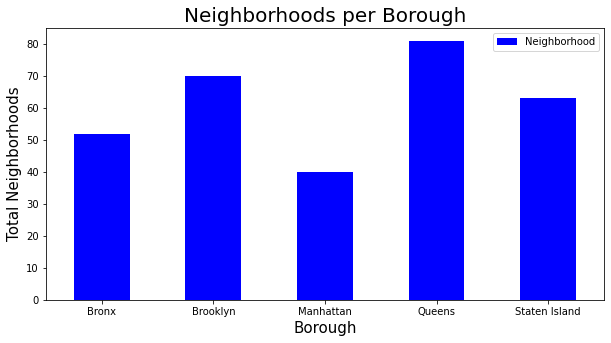

In [26]:
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Total Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

<h2>Total Filipino Restaurants Per Borough And Per Neighborhood</h2>

In [27]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
filipino_res_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    filipino_restaurants=venues[venues['Category']=='Filipino Restaurant']   
    print('(',count,'/',len(ny_data),')','Filipino Restaurants in '+Neighborhood+', '+Borough+':'+str(len(filipino_restaurants)))
    print(row)
    for resturant_detail in filipino_restaurants.values.tolist():
        id, name , category=resturant_detail
        filipino_res_ny = filipino_res_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Filipino Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.8947134741554, -73.8472019292043]
( 2 / 306 ) Filipino Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.8743024871941, -73.8299405100009]
( 3 / 306 ) Filipino Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.8875639741792, -73.8278078491621]
( 4 / 306 ) Filipino Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.8954457225429, -73.9056440233656]
( 5 / 306 ) Filipino Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.8908427883884, -73.9125868904809]
( 6 / 306 ) Filipino Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.8816956642597, -73.9028194129509]
( 7 / 306 ) Filipino Restaurants in South Beach, Staten Island:0
['Staten Island', 'South Beach', 40.5802556413166, -74.0795543894264]
( 8 / 306 ) Filipino Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.8765590705761, -73.9106610865368]
( 9 / 306 ) Filipino Restaurants in Po

In [33]:
display(filipino_res_ny)

,Borough,Neighborhood,ID,Name
0,Brooklyn,Carroll Gardens,591e55677247502fb9514269,Fob Restaurant
1,Manhattan,Lenox Hill,5f37249eae562379c5455e26,Bilao
2,Manhattan,East Village,5a73b1f49ef8ef531a1c08df,Mama Fina's
3,Manhattan,Lower East Side,50588bc6526260483ab2860e,Pig and Khao
4,Manhattan,Gramercy,4acb6fbcf964a520bec320e3,Grill 21
5,Queens,Woodside,53040a6e498ef035406f9cbf,House of Inasal
6,Staten Island,Rosebank,54c43136498ee8c2a685861e,Phil-Am Kusina


In [34]:
filipino_res_ny.shape

(7, 4)

<h3>Initial Findings</h3>
<p> There are only 7 Filipino Restaurants in New York City, majority of which are in Manhattan despite having the least amount of neighborhoods. The only borough that doesn't have a Filipino restaurant is the Bronx. This certainly shows a great opportunity for success with the small amount of competition present. </p>

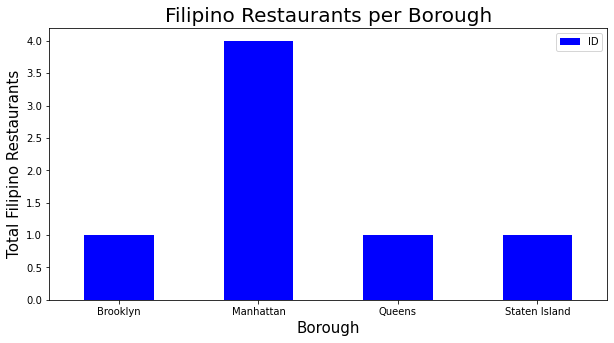

In [35]:
filipino_res_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Filipino Restaurants per Borough', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Total Filipino Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

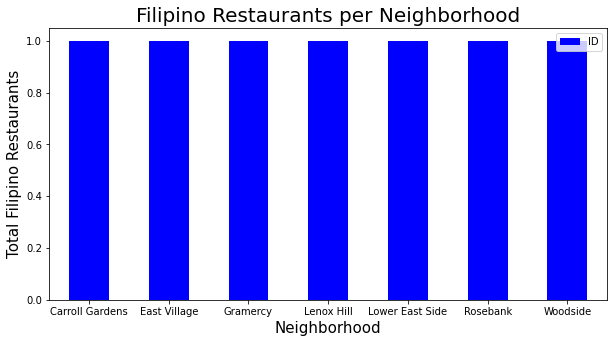

In [37]:
TopNeigh = 7 
filipino_res_ny.groupby('Neighborhood')['ID'].count().nlargest(TopNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Filipino Restaurants per Neighborhood', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Total Filipino Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

<h2>Rankings Of Filipino Restaurants In NYC</h2>

In [40]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
filipino_res_stats=pd.DataFrame(columns=column_names)
count=1
for row in filipino_res_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(filipino_res_ny),')','processed')
    filipino_res_stats = filipino_res_stats.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

{'meta': {'code': 200, 'requestId': '60b9947c1b7a593fe5c1fd1d'}, 'response': {'venue': {'id': '591e55677247502fb9514269', 'name': 'Fob Restaurant', 'contact': {'phone': '7188528994', 'formattedPhone': '(718) 852-8994', 'facebook': '660050157480185', 'facebookUsername': 'fobbrooklyn', 'facebookName': 'FOB Brooklyn'}, 'location': {'address': '271 Smith St', 'crossStreet': 'Degraw and Sackett', 'lat': 40.68265981062246, 'lng': -73.99316582968643, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68265981062246, 'lng': -73.99316582968643}, {'label': 'entrance', 'lat': 40.68263, 'lng': -73.993127}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['271 Smith St (Degraw and Sackett)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fob-restaurant/591e55677247502fb9514269', 'categories': [{'id': '4eb1bd1c3b7b55596b4a748f', 'name': 'Filipino Restaurant', 'pluralName': 'Filipino Restaurants'

In [41]:
display(filipino_res_stats)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Carroll Gardens,591e55677247502fb9514269,Fob Restaurant,63,8.1,29
1,Manhattan,Lenox Hill,5f37249eae562379c5455e26,Bilao,6,7.5,1
2,Manhattan,East Village,5a73b1f49ef8ef531a1c08df,Mama Fina's,46,8.2,14
3,Manhattan,Lower East Side,50588bc6526260483ab2860e,Pig and Khao,1082,9.1,300
4,Manhattan,Gramercy,4acb6fbcf964a520bec320e3,Grill 21,103,7.5,83
5,Queens,Woodside,53040a6e498ef035406f9cbf,House of Inasal,48,7.7,13
6,Staten Island,Rosebank,54c43136498ee8c2a685861e,Phil-Am Kusina,17,7.7,10


<h3>Additional Note</h3>
<p> Before proceeding with the analysis, the Dataframe values must be checked that they are in the correct format. If any numerical values are in string format, they must be converted into float for further analysis. In this case, Likes and Tips must be converted into float.</p>

In [43]:
filipino_res_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       7 non-null      object 
 1   Neighborhood  7 non-null      object 
 2   ID            7 non-null      object 
 3   Name          7 non-null      object 
 4   Likes         7 non-null      object 
 5   Rating        7 non-null      float64
 6   Tips          7 non-null      object 
dtypes: float64(1), object(6)
memory usage: 520.0+ bytes


In [44]:
filipino_res_stats['Likes'] = filipino_res_stats['Likes'].astype('float64')
filipino_res_stats['Tips'] = filipino_res_stats['Tips'].astype('float64')
filipino_res_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       7 non-null      object 
 1   Neighborhood  7 non-null      object 
 2   ID            7 non-null      object 
 3   Name          7 non-null      object 
 4   Likes         7 non-null      float64
 5   Rating        7 non-null      float64
 6   Tips          7 non-null      float64
dtypes: float64(3), object(4)
memory usage: 520.0+ bytes


In [45]:
filipino_res_stats.describe()

,Likes,Rating,Tips
count,7.000000,7.000000,7.000000
mean,195.000000,7.971429,64.285714
std,392.401155,0.567786,107.445667
min,6.000000,7.500000,1.000000
25%,31.500000,7.600000,11.500000
50%,48.000000,7.700000,14.000000
75%,83.000000,8.150000,56.000000
max,1082.000000,9.100000,300.000000


<h2>Filipino Restaurant With the Most Likes</h2>

In [46]:
filipino_res_stats.iloc[filipino_res_stats['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood             Lower East Side
ID              50588bc6526260483ab2860e
Name                        Pig and Khao
Likes                               1082
Rating                               9.1
Tips                                 300
Name: 3, dtype: object

<h2>Filipino Restaurant With the Highest Avg Rating</h2>

In [47]:
filipino_res_stats.iloc[filipino_res_stats['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood             Lower East Side
ID              50588bc6526260483ab2860e
Name                        Pig and Khao
Likes                               1082
Rating                               9.1
Tips                                 300
Name: 3, dtype: object

<h2>Filipino Restaurant With the Most Tips Provided</h2>

In [48]:
filipino_res_stats.iloc[filipino_res_stats['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood             Lower East Side
ID              50588bc6526260483ab2860e
Name                        Pig and Khao
Likes                               1082
Rating                               9.1
Tips                                 300
Name: 3, dtype: object

<h2>Top Neighborhoods By Avg Rating of Filipino Restaurants</h2>

In [49]:
ny_neighborhood_stats=filipino_res_stats.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
4,Lower East Side,9.1
1,East Village,8.2
0,Carroll Gardens,8.1
5,Rosebank,7.7
6,Woodside,7.7
2,Gramercy,7.5
3,Lenox Hill,7.5


<h2>Top Boroughs By Avg Rating of Filipino Restaurants</h2>

In [50]:
ny_borough_stats=filipino_res_stats.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Brooklyn,8.100
1,Manhattan,8.075
2,Queens,7.700
3,Staten Island,7.700


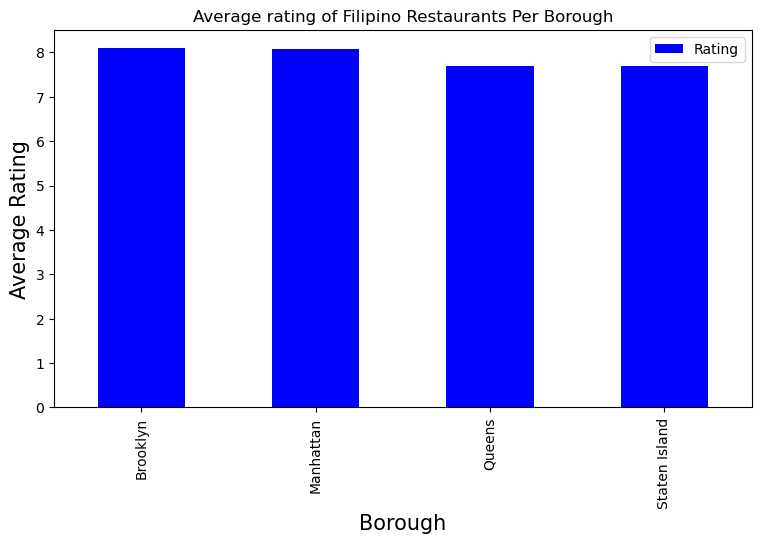

In [51]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Filipino Restaurants Per Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
filipino_res_stats.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

<h2>Visualize NYC Filipino Restaurants On A Map</h2>

<h3>Note</h3>
<p>Before generating the map, join the neighborhood stats dataset to original data to get longitude and latitude</p>

In [52]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Carroll Gardens,40.680548,-73.994655,8.1
1,Manhattan,East Village,40.727855,-73.982228,8.2
2,Manhattan,Gramercy,40.737218,-73.981377,7.5
3,Manhattan,Lenox Hill,40.768121,-73.958861,7.5
4,Manhattan,Lower East Side,40.717815,-73.980892,9.1
5,Staten Island,Rosebank,40.615313,-74.069807,7.7
6,Queens,Woodside,40.746357,-73.901843,7.7


<h2>Visualize The Dataset On A Map</h2>

In [53]:
# create map and display it
nyc_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [54]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(nyc_map)        
# add ratings to map
nyc_map.add_child(rating)

<h2>Results</h2>
<p>
<h3>What location(s) in New York City best serve Filipino cuisines?</h3>
Based on the above information, Manhattan and Brooklyn are the best locations for Filipino cuisine in NYC. Manhattan and Brooklyn have the best rated Filipino restaurants on average. Meanwhile, Staten Island and Queens have the lowest rated Filipino restaurants. Manhattan has variety with a total of 4 Filipino restaurants. Although Brooklyn only has one restaurant, Fob Restaurant, it is one of the highest rated Filipino restaurant according to the FourSquare data.
<h3>Where do most New Yorkers go to have the best Filipino food in the city?</h3>
It seems that majority of New Yorkers go to Pig and Khao in Manhattan for the best Filipino food. Pig and Khao received over 1,000 likes, 300 tips, and an average rating of 9.1 / 10.
<h3>In what Borough and Neighborhood should the entrepreneur open his/her Filipino restaurant for best chance of success?</h3>
Based on the analysis of the FourSquare data, it would be best to open a Filipino restaurant in Queens. The entrepreneur must consider the amount of competition in Manhattan and the high level of competition in Brooklyn with average ratings exceeding 8.0 out of 10.0. Given the lack of quality in Queens for Filipino food, it would be easier to garner success there where enthusiasts would benefit. In fact, Queens has a large Filipino population with real estate prices lower than Manhattan and Brooklyn. Furthermore, the largest concentration of Filipinos can be found in the Woodside Elmhurst/Jackson Heights area. 
<h3>Final Note</h3>
Please note that the analysis is dependent on the accuracy of the FourSquare data. Other third-party databases is necessary for a more updated and comprehensive analysis.</p>